In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install pytorch-lightning
!pip install pytorch-forecasting
!pip install cpflows

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.2/721.2 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 57.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.4/140.4 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 28.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 35.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.8/150.8 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 kB 7.0 MB/s eta 0:00:

In [122]:
import matplotlib.pyplot as plt
import torch
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from typing import Dict
from pytorch_forecasting import TimeSeriesDataSet
from pytorch_forecasting.models.nn import LSTM
from pytorch_forecasting.models.temporal_fusion_transformer import TemporalFusionTransformer
from pytorch_forecasting.data.encoders import NaNLabelEncoder
from pytorch_forecasting.models.nhits import NHiTS
from lightning.pytorch.utilities.model_summary import ModelSummary
from torch.nn.utils import rnn
from pytorch_forecasting.models.base_model import AutoRegressiveBaseModel
from pytorch_forecasting.models.nn import LSTM
from sklearn.preprocessing import MinMaxScaler
from datetime import timedelta
import lightning.pytorch as pl
from pytorch_forecasting import Baseline, NBeats, TimeSeriesDataSet
from lightning.pytorch.tuner import Tuner
from pytorch_forecasting.metrics import MAE, SMAPE, MQF2DistributionLoss, QuantileLoss

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
class_df = pd.read_csv('/content/drive/MyDrive/data_N.csv')
class_df['DD3'] = pd.to_datetime(class_df['DD']) - timedelta(days=3)
class_df['DD5'] = pd.to_datetime(class_df['DD']) - timedelta(days=5)
class_df['DD7'] = pd.to_datetime(class_df['DD']) - timedelta(days=7)
class_df['DD14'] = pd.to_datetime(class_df['DD']) - timedelta(days=14)
class_df['DD30'] = pd.to_datetime(class_df['DD']) - timedelta(days=30)
class_df['DD60'] = pd.to_datetime(class_df['DD']) - timedelta(days=60)
class_df['DD3'] = class_df['DD3'].astype(str)
class_df['DD5'] = class_df['DD5'].astype(str)
class_df['DD7'] = class_df['DD7'].astype(str)
class_df['DD14'] = class_df['DD14'].astype(str)
class_df['DD30'] = class_df['DD30'].astype(str)
class_df['DD60'] = class_df['DD60'].astype(str)

In [6]:
msc_temp = pd.read_csv('/content/drive/MyDrive/moscow_temp.csv', header=2)
msc_temp[['date', 'time']] = msc_temp['time'].str.split('T', expand=True)
msc_temp = pd.DataFrame(msc_temp.groupby('date')['temperature_2m (°C)'].mean().reset_index())
msc_temp['date'] = pd.to_datetime(msc_temp['date']).dt.strftime('%Y-%m-%d')
aed_temp = pd.read_csv('/content/drive/MyDrive/adler_temp.csv', header=2)
aed_temp[['date', 'time']] = aed_temp['time'].str.split('T', expand=True)
aed_temp = pd.DataFrame(aed_temp.groupby('date')['temperature_2m (°C)'].mean().reset_index())
aed_temp['date'] = pd.to_datetime(aed_temp['date']).dt.strftime('%Y-%m-%d')
ast_temp = pd.read_csv('/content/drive/MyDrive/astrakhan_temp.csv', header=2)
ast_temp[['date', 'time']] = ast_temp['time'].str.split('T', expand=True)
ast_temp = pd.DataFrame(ast_temp.groupby('date')['temperature_2m (°C)'].mean().reset_index())
ast_temp['date'] = pd.to_datetime(ast_temp['date']).dt.strftime('%Y-%m-%d')
usd_rub = pd.read_csv('/content/drive/MyDrive/USD_RUB.csv')[['Дата', 'Цена']]
usd_rub['Цена'] = usd_rub['Цена'].str.replace(',','.').astype('float')
jet_fuel = pd.read_csv('/content/drive/MyDrive/jet_fuel_strip.csv',
                       header=None,
                       names=('Date', 'Price'),
                       delimiter=';').dropna()
jet_fuel['Price'] = jet_fuel['Price'].str.replace(',','.').astype('float')
wheat = pd.read_csv('/content/drive/MyDrive/wheat.csv')[['Дата', 'Цена']]
wheat['Цена'] = wheat['Цена'].str.replace(',','.').astype('float')


usd_rub['Дата_i'] = pd.to_datetime(usd_rub['Дата'])
usd_rub = usd_rub.set_index('Дата_i')
jet_fuel['Date_i'] = pd.to_datetime(jet_fuel['Date'])
jet_fuel = jet_fuel.set_index('Date_i')
wheat['Дата_i'] = pd.to_datetime(wheat['Дата'])
wheat = wheat.set_index('Дата_i')

usd_rub = usd_rub.asfreq('D')
usd_rub['Цена'] = usd_rub['Цена'].fillna(method='ffill')
usd_rub['Дата'] = usd_rub.index
usd_rub['Дата'] = pd.to_datetime(usd_rub['Дата']).dt.strftime('%Y-%m-%d')

wheat = wheat.asfreq('D')
wheat['Цена'] = wheat['Цена'].fillna(method='ffill')
wheat['Дата'] = wheat.index
wheat['Дата'] = pd.to_datetime(wheat['Дата']).dt.strftime('%Y-%m-%d')

In [7]:
svo_aer = class_df.loc[(class_df['SORG']=='SVO') & (class_df['SDST']=='AER')]
aer_svo = class_df.loc[(class_df['SORG']=='AER') & (class_df['SDST']=='SVO')]

In [8]:
svo_aer = pd.merge(svo_aer, aed_temp, left_on='DD', right_on='date', how='inner')
svo_aer = pd.merge(svo_aer, aed_temp, left_on='DD3', right_on='date', how='inner')
svo_aer = pd.merge(svo_aer, aed_temp, left_on='DD5', right_on='date', how='inner')
svo_aer = pd.merge(svo_aer, aed_temp, left_on='DD7', right_on='date', how='inner')
svo_aer = pd.merge(svo_aer, aed_temp, left_on='DD14', right_on='date', how='inner')
svo_aer = pd.merge(svo_aer, aed_temp, left_on='DD30', right_on='date', how='inner')
svo_aer = pd.merge(svo_aer, aed_temp, left_on='DD60', right_on='date', how='inner')
svo_aer = pd.merge(svo_aer, msc_temp, left_on='DD', right_on='date', how='inner')
svo_aer = pd.merge(svo_aer, msc_temp, left_on='DD3', right_on='date', how='inner')
svo_aer = pd.merge(svo_aer, msc_temp, left_on='DD5', right_on='date', how='inner')
svo_aer = pd.merge(svo_aer, msc_temp, left_on='DD7', right_on='date', how='inner')
svo_aer = pd.merge(svo_aer, msc_temp, left_on='DD14', right_on='date', how='inner')
svo_aer = pd.merge(svo_aer, msc_temp, left_on='DD30', right_on='date', how='inner')
svo_aer = pd.merge(svo_aer, msc_temp, left_on='DD60', right_on='date', how='inner')

In [9]:
aer_svo = pd.merge(aer_svo, msc_temp, left_on='DD', right_on='date', how='inner')
aer_svo = pd.merge(aer_svo, msc_temp, left_on='DD3', right_on='date', how='inner')
aer_svo = pd.merge(aer_svo, msc_temp, left_on='DD5', right_on='date', how='inner')
aer_svo = pd.merge(aer_svo, msc_temp, left_on='DD7', right_on='date', how='inner')
aer_svo = pd.merge(aer_svo, msc_temp, left_on='DD14', right_on='date', how='inner')
aer_svo = pd.merge(aer_svo, msc_temp, left_on='DD30', right_on='date', how='inner')
aer_svo = pd.merge(aer_svo, msc_temp, left_on='DD60', right_on='date', how='inner')
aer_svo = pd.merge(aer_svo, aed_temp, left_on='DD', right_on='date', how='inner')
aer_svo = pd.merge(aer_svo, aed_temp, left_on='DD3', right_on='date', how='inner')
aer_svo = pd.merge(aer_svo, aed_temp, left_on='DD5', right_on='date', how='inner')
aer_svo = pd.merge(aer_svo, aed_temp, left_on='DD7', right_on='date', how='inner')
aer_svo = pd.merge(aer_svo, aed_temp, left_on='DD14', right_on='date', how='inner')
aer_svo = pd.merge(aer_svo, aed_temp, left_on='DD30', right_on='date', how='inner')
aer_svo = pd.merge(aer_svo, aed_temp, left_on='DD60', right_on='date', how='inner')

In [10]:
class_df = pd.concat([svo_aer, aer_svo], ignore_index=True).sort_values(by=['FLT_NUM', 'DD'])
class_df

,DD2,DD,SORG,SDST,FLT_NUM,SEG_CLASS_CODE,PASS_BK,DD3,DD5,DD7,...,date_y,temperature_2m (°C)_y,date_x,temperature_2m (°C)_x,date_y,temperature_2m (°C)_y,date_x,temperature_2m (°C)_x,date_y,temperature_2m (°C)_y
0,2018-01-01,2018-01-01,SVO,AER,1118,0,0.0,2017-12-29,2017-12-27,2017-12-25,...,2017-12-27,0.975000,2017-12-25,-4.345833,2017-12-18,-0.550000,2017-12-02,0.108333,2017-11-02,-2.816667
14,2018-01-02,2018-01-02,SVO,AER,1118,0,0.0,2017-12-30,2017-12-28,2017-12-26,...,2017-12-28,0.579167,2017-12-26,-0.166667,2017-12-19,-0.354167,2017-12-03,-1.633333,2017-11-03,-2.041667
28,2018-01-03,2018-01-03,SVO,AER,1118,0,0.0,2017-12-31,2017-12-29,2017-12-27,...,2017-12-29,2.020833,2017-12-27,0.975000,2017-12-20,-0.408333,2017-12-04,-0.779167,2017-11-04,-0.045833
42,2018-01-04,2018-01-04,SVO,AER,1118,0,0.0,2018-01-01,2017-12-30,2017-12-28,...,2017-12-30,0.804167,2017-12-28,0.579167,2017-12-21,-1.979167,2017-12-05,-4.170833,2017-11-05,2.395833
56,2018-01-05,2018-01-05,SVO,AER,1118,0,0.0,2018-01-02,2017-12-31,2017-12-29,...,2017-12-31,0.512500,2017-12-29,2.020833,2017-12-22,-5.070833,2017-12-06,-4.304167,2017-11-06,3.212500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20383,2019-12-27,2019-12-27,AER,SVO,1153,N,18.0,2019-12-24,2019-12-22,2019-12-20,...,2019-12-22,12.929167,2019-12-20,9.691667,2019-12-13,10.812500,2019-11-27,13.958333,2019-10-28,17.054167
20397,2019-12-28,2019-12-28,AER,SVO,1153,N,18.0,2019-12-25,2019-12-23,2019-12-21,...,2019-12-23,15.604167,2019-12-21,10.962500,2019-12-14,14.454167,2019-11-28,10.962500,2019-10-29,17.225000
20411,2019-12-29,2019-12-29,AER,SVO,1153,N,35.0,2019-12-26,2019-12-24,2019-12-22,...,2019-12-24,15.900000,2019-12-22,12.929167,2019-12-15,13.950000,2019-11-29,13.895833,2019-10-30,13.800000
20425,2019-12-30,2019-12-30,AER,SVO,1153,N,8.0,2019-12-27,2019-12-25,2019-12-23,...,2019-12-25,15.454167,2019-12-23,15.604167,2019-12-16,11.470833,2019-11-30,11.845833,2019-10-31,11.254167


In [11]:
group = class_df['FLT_NUM']

In [12]:
class_df = pd.merge(class_df, usd_rub, left_on='DD', right_on='Дата', how='inner')
class_df = pd.merge(class_df, usd_rub, left_on='DD3', right_on='Дата', how='inner')
class_df = pd.merge(class_df, usd_rub, left_on='DD5', right_on='Дата', how='inner')
class_df = pd.merge(class_df, usd_rub, left_on='DD7', right_on='Дата', how='inner')
class_df = pd.merge(class_df, usd_rub, left_on='DD14', right_on='Дата', how='inner')
class_df = pd.merge(class_df, usd_rub, left_on='DD30', right_on='Дата', how='inner')
class_df = pd.merge(class_df, usd_rub, left_on='DD60', right_on='Дата', how='inner')
class_df = pd.merge(class_df, wheat, left_on='DD', right_on='Дата', how='inner')
class_df = pd.merge(class_df, wheat, left_on='DD3', right_on='Дата', how='inner')
class_df = pd.merge(class_df, wheat, left_on='DD5', right_on='Дата', how='inner')
class_df = pd.merge(class_df, wheat, left_on='DD7', right_on='Дата', how='inner')
class_df = pd.merge(class_df, wheat, left_on='DD14', right_on='Дата', how='inner')
class_df = pd.merge(class_df, wheat, left_on='DD30', right_on='Дата', how='inner')
class_df = pd.merge(class_df, wheat, left_on='DD60', right_on='Дата', how='inner')
class_df = class_df.drop('DD2', axis=1)
class_df = class_df.drop('SEG_CLASS_CODE', axis=1)

In [13]:
class_df = class_df.sort_values(by=['FLT_NUM', 'DD'])

In [14]:
class_df.columns = ['DD', 'SORG', 'SDST', 'FLT_NUM', 'PASS_BK', 'DD3', 'DD5',
       'DD7', 'DD14', 'DD30', 'DD60', 'date_x', 'temp_arr',
       'date_y', 'temp_arr_3', 'date_x', 'temp_arr_5',
       'date_y', 'temp_arr_7', 'date_x', 'temp_arr_14',
       'date_y', 'temp_arr_30', 'date_x', 'temp_arr_60',
       'date_y', 'temp_dep', 'date_x', 'temp_dep_3',
       'date_y', 'temp_dep_5', 'date_x', 'temp_dep_7',
       'date_y', 'temp_dep_14', 'date_x', 'temp_dep_30',
       'date_y', 'temp_dep_60', 'Дата_x', 'usd', 'Дата_y',
       'usd3', 'Дата_x', 'usd5', 'Дата_y', 'usd7', 'Дата_x', 'usd14',
       'Дата_y', 'usd30', 'Дата_x', 'usd60', 'Дата_y', 'wheat', 'Дата_x',
       'wheat3', 'Дата_y', 'wheat5', 'Дата_x', 'wheat7', 'Дата_y', 'wheat14',
       'Дата_x', 'wheat30', 'Дата_y', 'wheat60']
class_df = class_df[['DD', 'PASS_BK', 'temp_arr',
       'temp_arr_3', 'temp_arr_5',
       'temp_arr_7', 'temp_arr_14',
       'temp_arr_30', 'temp_arr_60',
       'temp_dep', 'temp_dep_3',
       'temp_dep_5', 'temp_dep_7',
       'temp_dep_14', 'temp_dep_30',
       'temp_dep_60', 'usd',
       'usd3', 'usd5', 'usd7', 'usd14',
       'usd30', 'usd60', 'wheat',
       'wheat3', 'wheat5', 'wheat7', 'wheat14',
       'wheat30', 'wheat60']]
class_df['dow'] = pd.to_datetime(class_df['DD']).dt.dayofweek.astype(str)
class_df = class_df.set_index('DD')
class_df = class_df.loc[:,~class_df.columns.duplicated()].copy()
class_df

,PASS_BK,temp_arr,temp_arr_3,temp_arr_5,temp_arr_7,temp_arr_14,temp_arr_30,temp_arr_60,temp_dep,temp_dep_3,...,usd30,usd60,wheat,wheat3,wheat5,wheat7,wheat14,wheat30,wheat60,dow
DD,,,,,,,,,,,,,,,,,,,,,
2018-01-01,0.0,9.029167,10.312500,10.112500,7.170833,14.729167,13.120833,6.183333,-0.308333,2.020833,...,59.3491,59.7256,427.00,427.00,428.00,424.75,420.50,409.25,418.50,0
2018-01-02,0.0,7.745833,13.004167,9.491667,8.141667,11.341667,14.633333,7.666667,0.529167,0.804167,...,59.3491,59.7256,451.00,427.00,427.75,422.25,419.50,409.25,418.50,1
2018-01-03,0.0,7.866667,12.575000,10.312500,10.112500,9.550000,16.616667,9.591667,1.441667,0.512500,...,56.6023,56.9215,505.50,427.00,427.00,428.00,423.50,433.25,433.25,2
2018-01-04,0.0,10.387500,9.029167,13.004167,9.491667,8.762500,10.283333,11.145833,0.254167,-0.308333,...,57.0974,57.0558,505.50,427.00,427.00,427.75,427.00,425.00,426.00,3
2018-01-05,0.0,11.233333,7.745833,12.575000,10.312500,7.479167,4.695833,15.029167,-1.229167,0.529167,...,57.0974,57.0558,529.75,451.00,427.00,427.00,424.75,434.00,426.00,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-27,18.0,-1.300000,2.995833,2.562500,-0.404167,0.083333,-1.695833,5.054167,10.516667,15.900000,...,63.9615,63.7520,556.25,541.00,542.25,542.25,539.25,528.50,511.75,4
2019-12-28,18.0,-1.512500,0.529167,5.375000,0.441667,-0.620833,-1.658333,2.891667,7.616667,15.454167,...,64.0735,63.9463,556.25,541.00,539.50,542.25,539.25,526.12,511.50,5
2019-12-29,35.0,-2.845833,-0.375000,2.995833,2.562500,0.287500,1.008333,-1.029167,8.937500,12.520833,...,64.3195,63.8536,556.25,549.00,541.00,542.25,539.25,547.50,509.25,6


In [15]:
scaler = MinMaxScaler(feature_range=(0, 100))
class_df_X = class_df.copy()
target = class_df_X['PASS_BK'].astype(float)
class_df_X = class_df_X.drop(['PASS_BK', 'dow'], axis=1)
class_df_X = scaler.fit_transform(class_df_X)
class_df_X = pd.DataFrame(class_df_X)

In [16]:
flight_nums = [1118, 1119, 1120, 1121, 1122, 1123, 1124, 1125, 1126, 1127, 1128,
               1129, 1130, 1131, 1132, 1133, 1134, 1135, 1136, 1137, 1138, 1139,
               1140, 1141, 1148, 1151, 1152, 1153]
class_df_X['dow'] = class_df['dow'].values
class_df_X['time_idx'] = np.tile(np.arange(730), int(len(class_df_X) / 730))
class_df_X['group'] = np.repeat(flight_nums, 730)
class_df_X['value'] = target.values.astype('float32')
class_df_X.columns = ['temp_arr',
       'temp_arr_3', 'temp_arr_5',
       'temp_arr_7', 'temp_arr_14',
       'temp_arr_30', 'temp_arr_60',
       'temp_dep', 'temp_dep_3',
       'temp_dep_5', 'temp_dep_7',
       'temp_dep_14', 'temp_dep_30',
       'temp_dep_60', 'usd',
       'usd3', 'usd5', 'usd7', 'usd14',
       'usd30', 'usd60', 'wheat',
       'wheat3', 'wheat5', 'wheat7', 'wheat14',
       'wheat30', 'wheat60', 'dow', 'time_idx', 'group', 'value']


In [17]:
class_df_X['group'] = class_df_X['group'].astype('str')

In [18]:
class_df_X = class_df_X.loc[~(class_df_X['value']==0)]

In [19]:
class_df_X = class_df_X.sort_values(by=['time_idx', 'group'])

<Axes: >

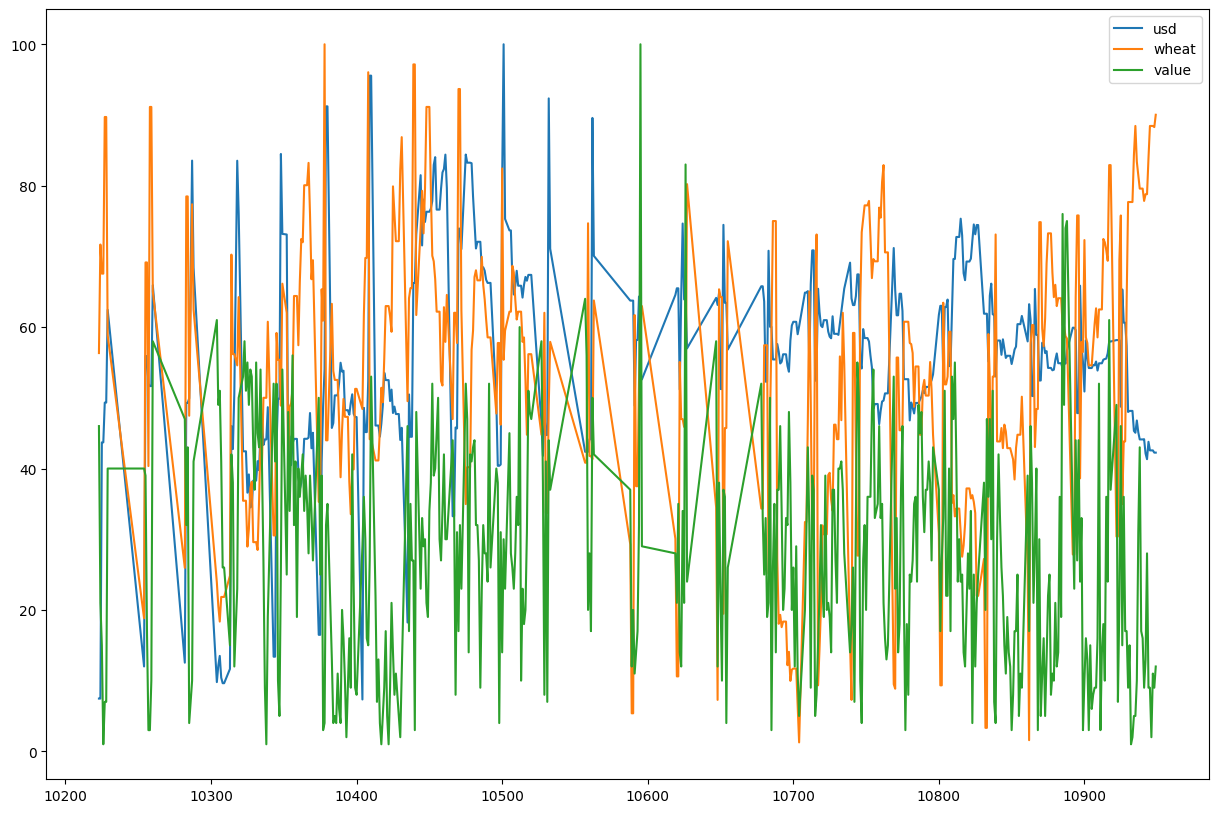

In [20]:
class_df_X.loc[class_df_X['group']=='1132'].drop(['time_idx', 'group', 'temp_arr',
       'temp_arr_3', 'temp_arr_5',
       'temp_arr_7', 'temp_arr_14',
       'temp_arr_30', 'temp_arr_60',
       'temp_dep', 'temp_dep_3',
       'temp_dep_5', 'temp_dep_7',
       'temp_dep_14', 'temp_dep_30',
       'temp_dep_60',
       'wheat3', 'wheat5', 'wheat7', 'wheat14',
       'wheat30', 'wheat60', 'usd3', 'usd5', 'usd7', 'usd14',
       'usd30', 'usd60'], axis=1)[:].plot(figsize=(15, 10))

In [21]:
class_df_X

,temp_arr,temp_arr_3,temp_arr_5,temp_arr_7,temp_arr_14,temp_arr_30,temp_arr_60,temp_dep,temp_dep_3,temp_dep_5,...,wheat3,wheat5,wheat7,wheat14,wheat30,wheat60,dow,time_idx,group,value
5110,40.499881,44.949455,42.951524,32.786755,40.038207,41.295869,35.708032,58.337977,60.789620,60.407546,...,6.645570,7.278481,5.221519,2.531646,11.748999,16.688919,0,0,1125,46.0
6570,40.499881,44.949455,42.951524,32.786755,40.038207,41.295869,35.708032,58.337977,60.789620,60.407546,...,6.645570,7.278481,5.221519,2.531646,11.748999,16.688919,0,0,1127,60.0
8760,58.337977,60.789620,60.407546,54.787869,69.227095,66.154581,52.901377,40.499881,44.949455,42.951524,...,6.645570,7.278481,5.221519,2.531646,11.748999,16.688919,0,0,1130,3.0
12410,40.499881,44.949455,42.951524,32.786755,40.038207,41.295869,35.708032,58.337977,60.789620,60.407546,...,6.645570,7.278481,5.221519,2.531646,11.748999,16.688919,0,0,1135,43.0
16790,40.499881,44.949455,42.951524,32.786755,40.038207,41.295869,35.708032,58.337977,60.789620,60.407546,...,6.645570,7.278481,5.221519,2.531646,11.748999,16.688919,0,0,1141,35.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15329,57.414630,55.639577,65.008358,71.463822,58.218578,60.757781,62.572634,43.484836,38.199475,40.372522,...,88.449367,83.860759,78.797468,88.449367,85.580774,70.627503,1,729,1138,18.0
16059,43.484836,38.199475,40.372522,46.812067,43.930590,35.349837,39.520815,57.414630,55.639577,65.008358,...,88.449367,83.860759,78.797468,88.449367,85.580774,70.627503,1,729,1139,9.0
16789,57.414630,55.639577,65.008358,71.463822,58.218578,60.757781,62.572634,43.484836,38.199475,40.372522,...,88.449367,83.860759,78.797468,88.449367,85.580774,70.627503,1,729,1140,31.0
19709,57.414630,55.639577,65.008358,71.463822,58.218578,60.757781,62.572634,43.484836,38.199475,40.372522,...,88.449367,83.860759,78.797468,88.449367,85.580774,70.627503,1,729,1152,11.0


In [56]:
dataset_with_covariates = TimeSeriesDataSet(
    class_df_X[:-2000],
    group_ids=["group"],
    target="value",
    time_idx="time_idx",
    min_encoder_length=14,
    max_encoder_length=14,
    min_prediction_length=1,
    max_prediction_length=1,
    time_varying_known_reals=['temp_arr',
       'temp_arr_3', 'temp_arr_5',
       'temp_arr_7', 'temp_arr_14',
       'temp_arr_30', 'temp_arr_60',
       'temp_dep', 'temp_dep_3',
       'temp_dep_5', 'temp_dep_7',
       'temp_dep_14', 'temp_dep_30',
       'temp_dep_60', 'usd',
       'usd3', 'usd5', 'usd7', 'usd14',
       'usd30', 'usd60', 'wheat',
       'wheat3', 'wheat5', 'wheat7', 'wheat14',
       'wheat30', 'wheat60'],
    time_varying_known_categoricals=['dow'],
    static_categoricals=["group"],
    categorical_encoders={
        'group': NaNLabelEncoder(add_nan=True),
        'dow': NaNLabelEncoder(add_nan=True),
    },
    allow_missing_timesteps=True
)

val_dataset_with_covariates = TimeSeriesDataSet.from_dataset(dataset_with_covariates,
                                                             class_df_X,
                                                             predict=True,
                                                             stop_randomization=True)

In [57]:
class LSTMModel(AutoRegressiveBaseModel):
    def __init__(
        self,
        target: str,
        target_lags: Dict[str, Dict[str, int]],
        n_layers: int,
        hidden_size: int,
        dropout: float = 0.2,
        **kwargs,
    ):
        # arguments target and target_lags are required for autoregressive models
        # even though target_lags cannot be used without covariates
        # saves arguments in signature to `.hparams` attribute, mandatory call - do not skip this
        self.save_hyperparameters()
        # pass additional arguments to BaseModel.__init__, mandatory call - do not skip this
        super().__init__(**kwargs)

        # use version of LSTM that can handle zero-length sequences
        self.lstm = LSTM(
            hidden_size=self.hparams.hidden_size,
            input_size=28,
            num_layers=self.hparams.n_layers,
            dropout=self.hparams.dropout,
            batch_first=True,
        )
        self.output_layer = nn.Linear(self.hparams.hidden_size, 1)

    def encode(self, x: Dict[str, torch.Tensor]):
        # we need at least one encoding step as because the target needs to be lagged by one time step
        # because we use the custom LSTM, we do not have to require encoder lengths of > 1
        # but can handle lengths of >= 1
        assert x["encoder_lengths"].min() >= 1
        input_vector = x["encoder_cont"].clone()
        # lag target by one
        input_vector[..., self.target_positions] = torch.roll(
            input_vector[..., self.target_positions], shifts=1, dims=1
        )
        input_vector = input_vector[:, 1:]  # first time step cannot be used because of lagging

        # determine effective encoder_length length
        effective_encoder_lengths = x["encoder_lengths"] - 1
        # run through LSTM network
        _, hidden_state = self.lstm(
            input_vector, lengths=effective_encoder_lengths, enforce_sorted=True  # passing the lengths directly
        )  # second ouput is not needed (hidden state)
        return hidden_state

    def decode(self, x: Dict[str, torch.Tensor], hidden_state):
        # again lag target by one
        input_vector = x["decoder_cont"].clone()
        input_vector[..., self.target_positions] = torch.roll(
            input_vector[..., self.target_positions], shifts=1, dims=1
        )
        # but this time fill in missing target from encoder_cont at the first time step instead of throwing it away
        last_encoder_target = x["encoder_cont"][
            torch.arange(x["encoder_cont"].size(0), device=x["encoder_cont"].device),
            x["encoder_lengths"] - 1,
            self.target_positions.unsqueeze(-1),
        ].T
        input_vector[:, 0, self.target_positions] = last_encoder_target

        if self.training:  # training mode
            lstm_output, _ = self.lstm(input_vector, hidden_state, lengths=x["decoder_lengths"], enforce_sorted=False)

            # transform into right shape
            prediction = self.output_layer(lstm_output)
            prediction = self.transform_output(prediction, target_scale=x["target_scale"])

            # predictions are not yet rescaled
            return prediction

        else:  # prediction mode
            target_pos = self.target_positions

            def decode_one(idx, lagged_targets, hidden_state):
                x = input_vector[:, [idx]]
                # overwrite at target positions
                x[:, 0, target_pos] = lagged_targets[-1]  # take most recent target (i.e. lag=1)
                lstm_output, hidden_state = self.lstm(x, hidden_state)
                # transform into right shape
                prediction = self.output_layer(lstm_output)[:, 0]  # take first timestep
                return prediction, hidden_state

            # make predictions which are fed into next step
            output = self.decode_autoregressive(
                decode_one,
                first_target=input_vector[:, 0, target_pos],
                first_hidden_state=hidden_state,
                target_scale=x["target_scale"],
                n_decoder_steps=input_vector.size(1),
            )

            # predictions are already rescaled
            return output

    def forward(self, x: Dict[str, torch.Tensor]) -> Dict[str, torch.Tensor]:
        hidden_state = self.encode(x)  # encode to hidden state
        output = self.decode(x, hidden_state)  # decode leveraging hidden state

        return self.to_network_output(prediction=output)

In [58]:
model = LSTMModel.from_dataset(dataset_with_covariates,
                               n_layers=3,
                               hidden_size=256,
                               weight_decay=1e-4,
                               optimizer="AdamW")
model.load_state_dict(torch.load('/content/drive/MyDrive/aeroflot_4gpu.pt'))

<All keys matched successfully>

In [25]:
train_dataloader = dataset_with_covariates.to_dataloader(train=True,
                                                   batch_size=64,
                                                   num_workers=0)

val_dataloader = val_dataset_with_covariates.to_dataloader(train=False,
                                                   batch_size=64,
                                                   num_workers=0,
                                                   shuffle=False)

trainer = pl.Trainer(
    max_epochs=500,
    accelerator="cpu",
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)

trainer.fit(
    model,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: 
  | Name            | Type       | Params
-----------------------------------------------
0 | loss            | SMAPE      | 0     
1 | logging_metrics | ModuleList | 0     
2 | lstm            | LSTM       | 1.3 M 
3 | output_layer    | Linear     | 257   
-----------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.383     Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name           

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


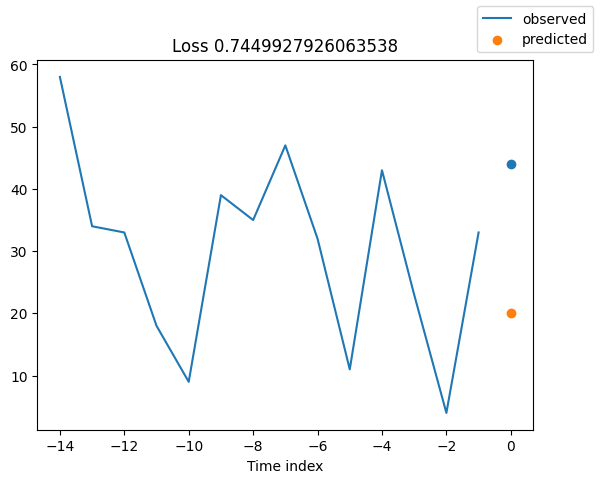

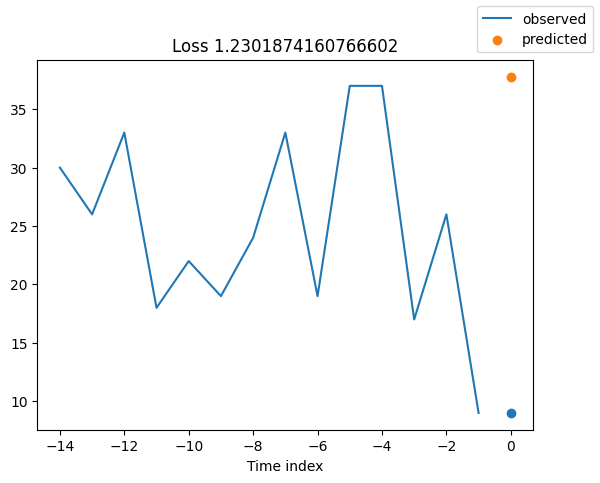

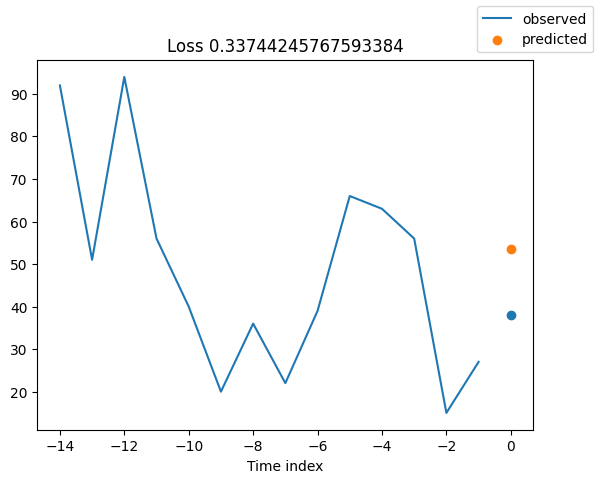

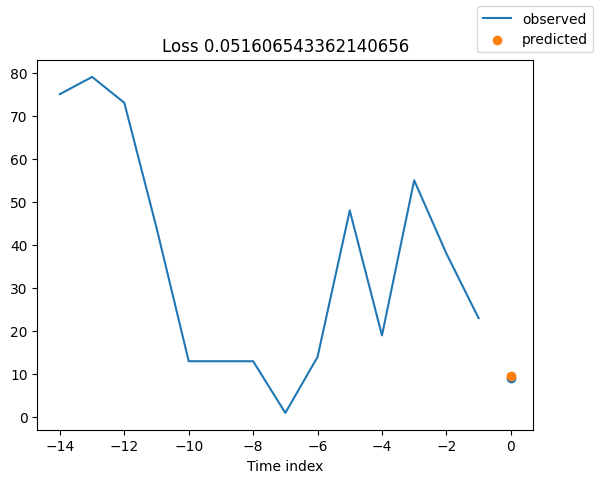

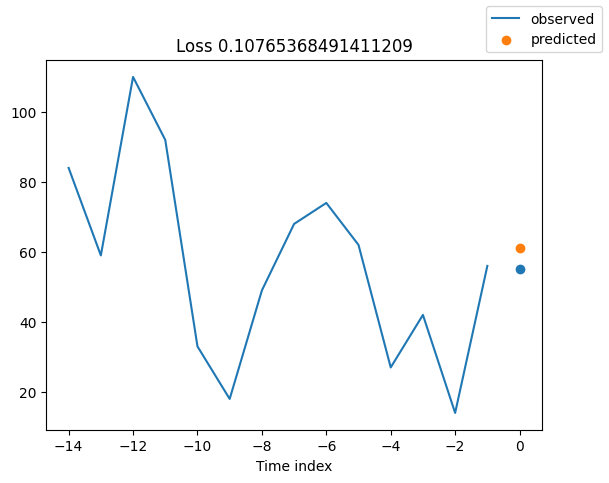

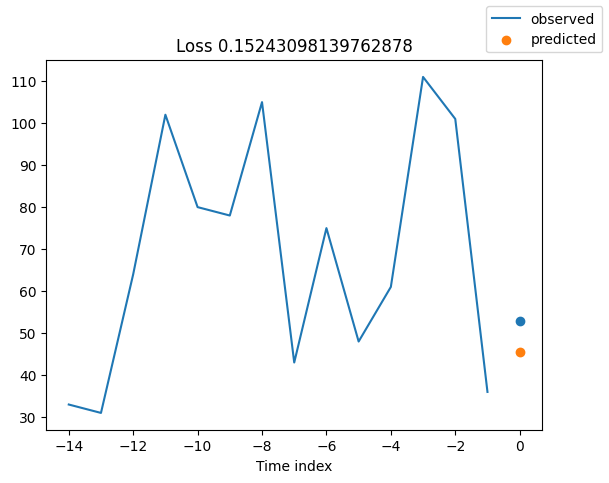

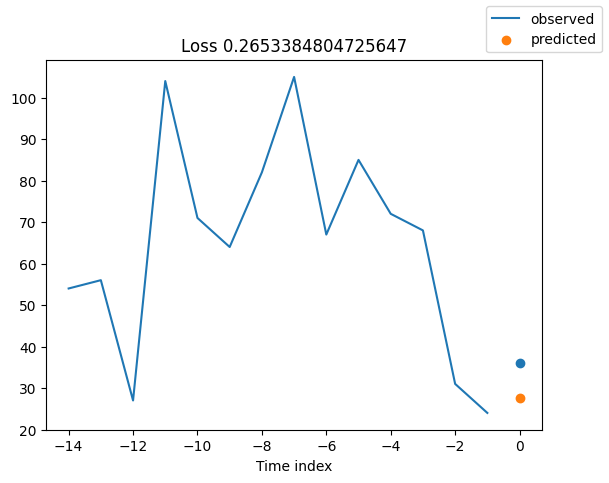

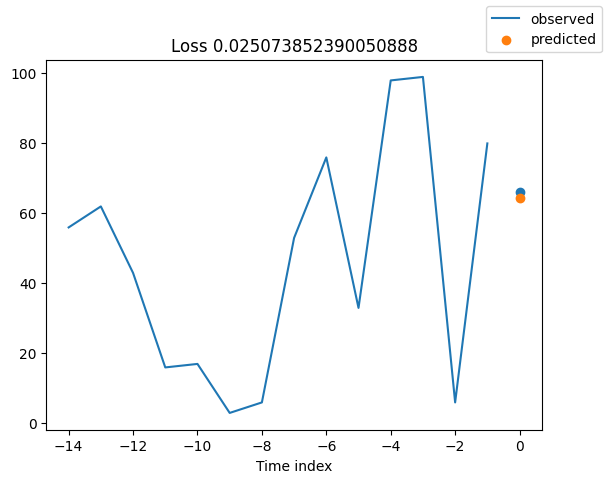

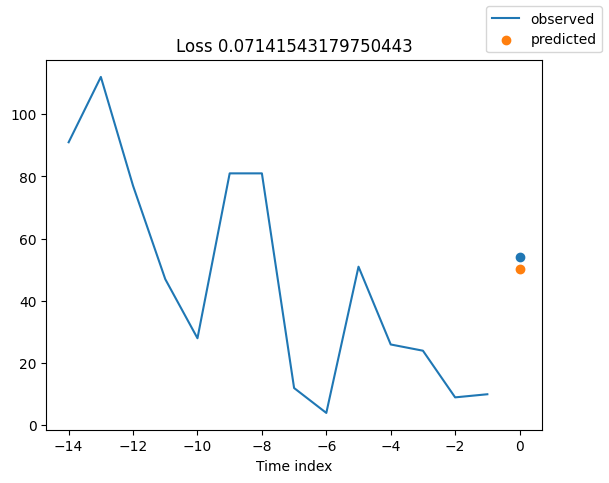

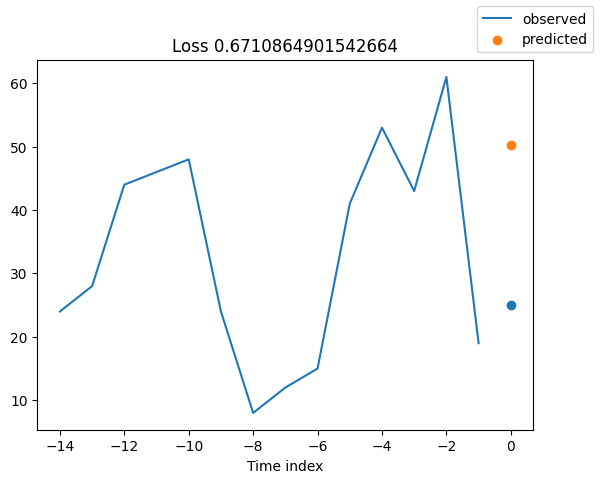

In [26]:
raw_predictions = model.predict(train_dataloader, mode="raw", return_x=True, trainer_kwargs=dict(accelerator="cpu"))
for idx in range(10):  # plot 10 examples
    model.plot_prediction(raw_predictions.x, raw_predictions.output, idx=idx, add_loss_to_title=True)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


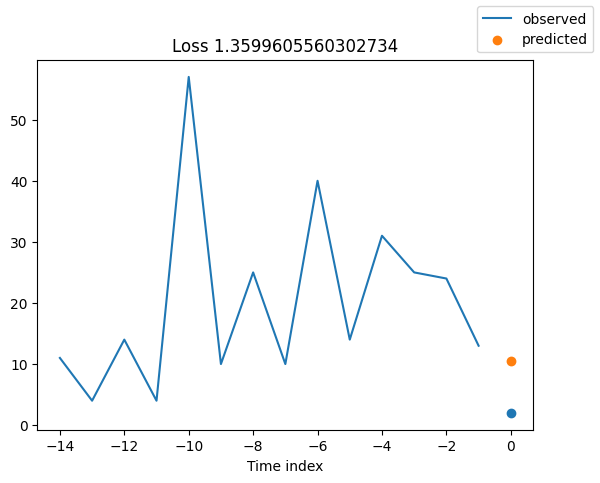

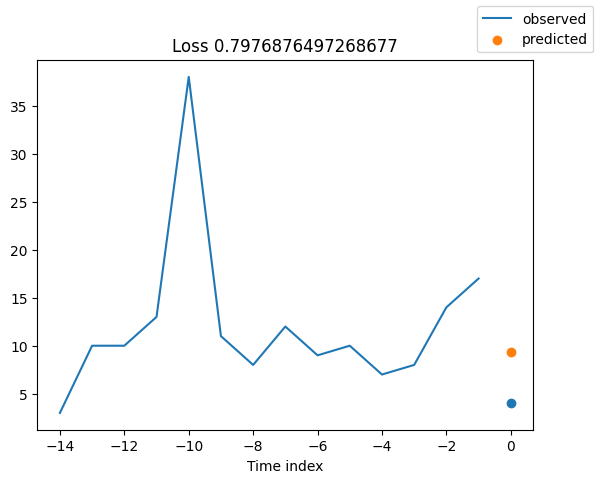

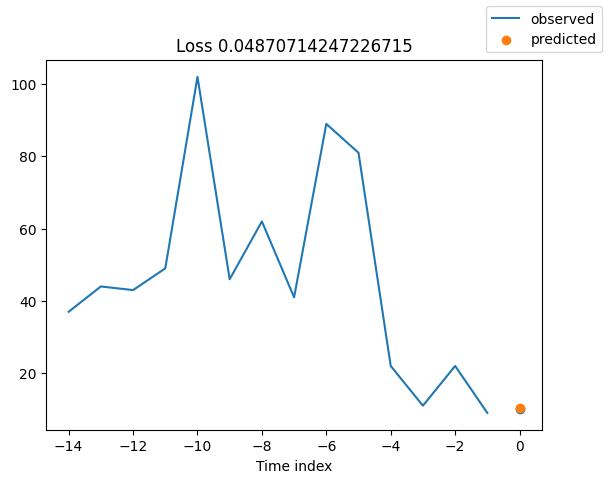

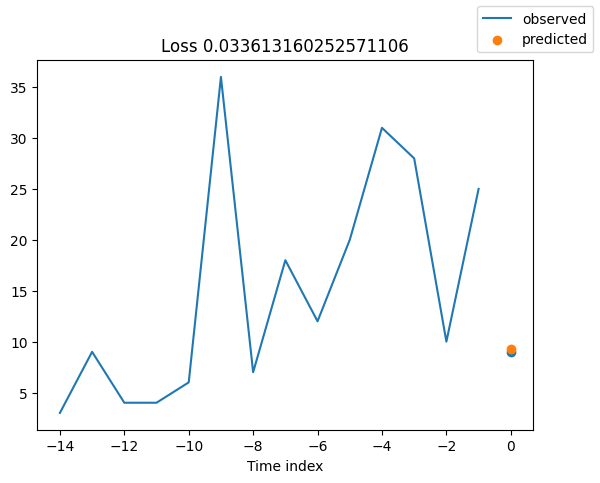

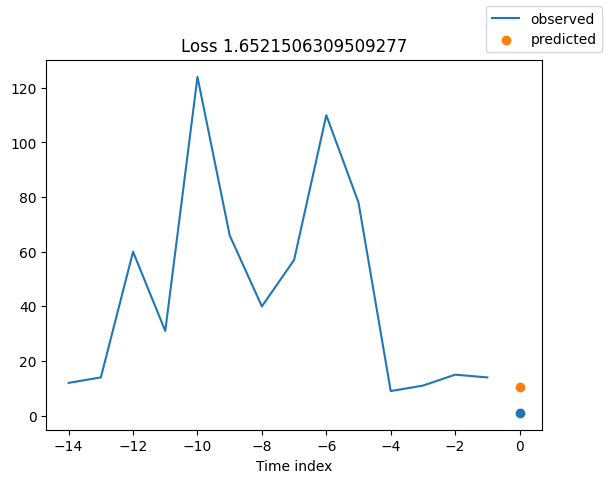

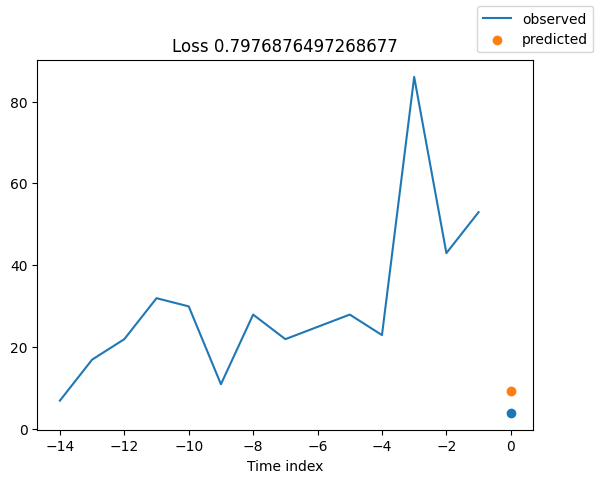

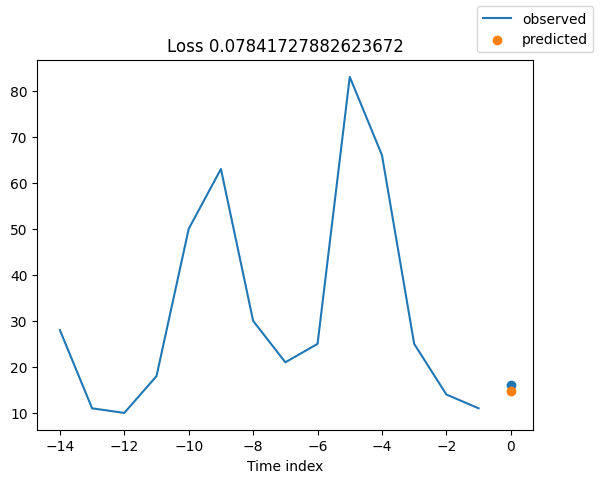

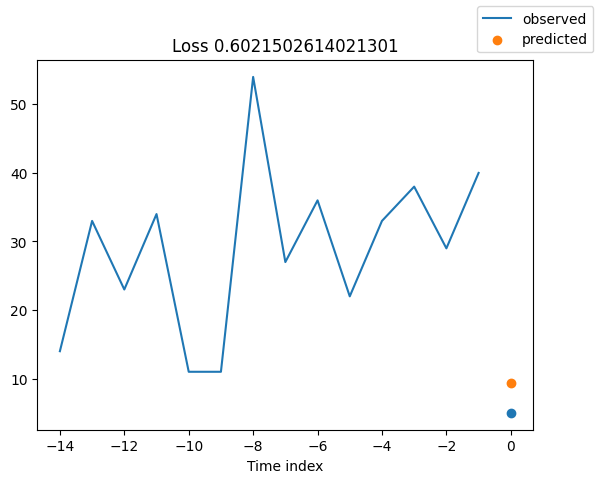

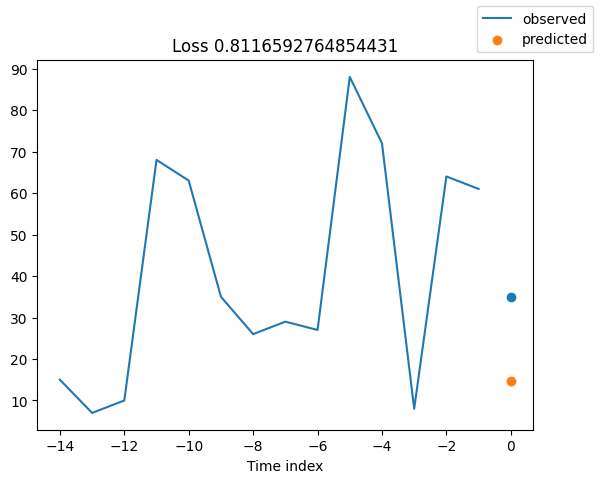

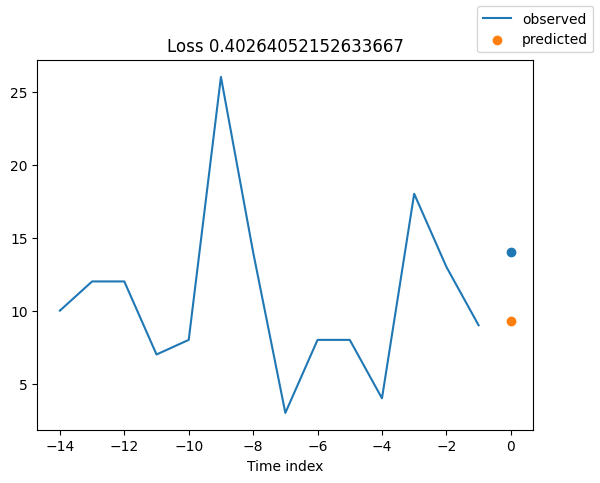

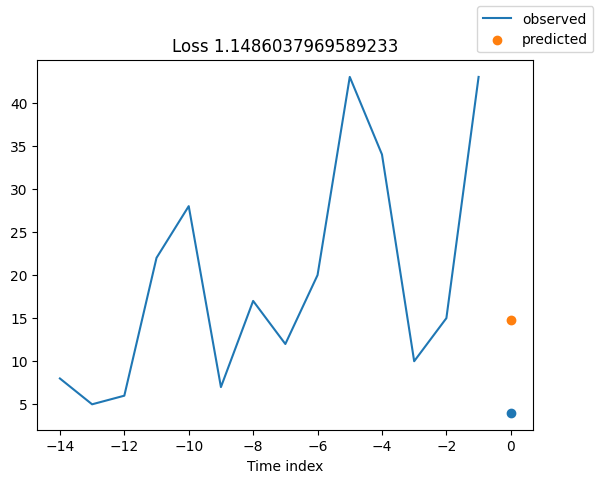

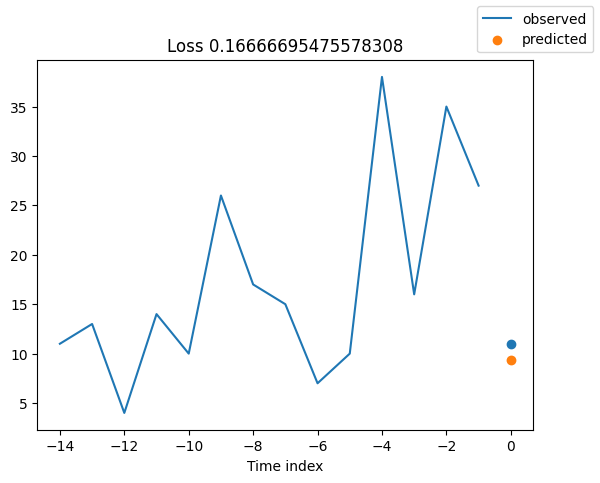

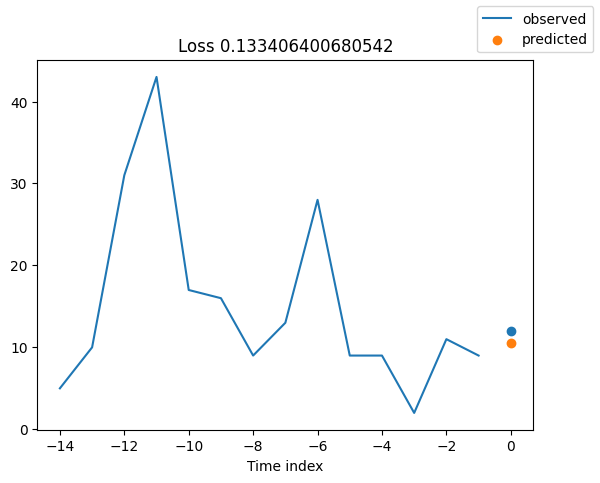

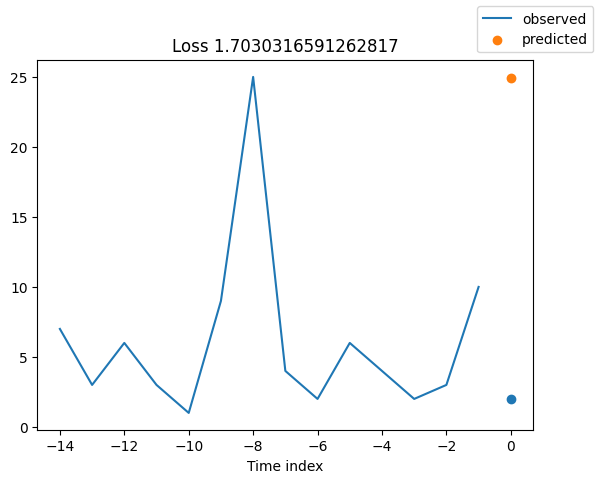

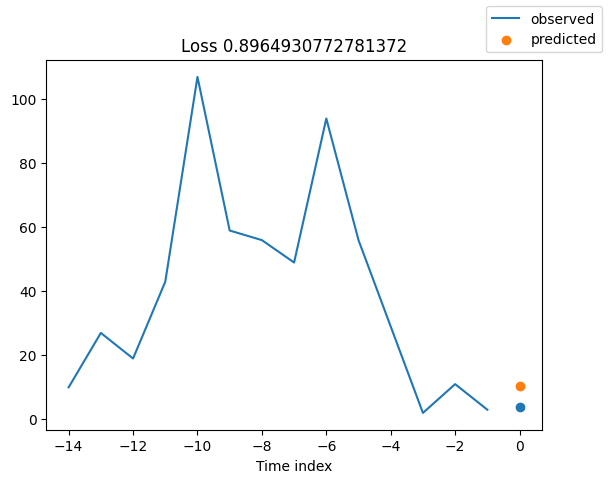

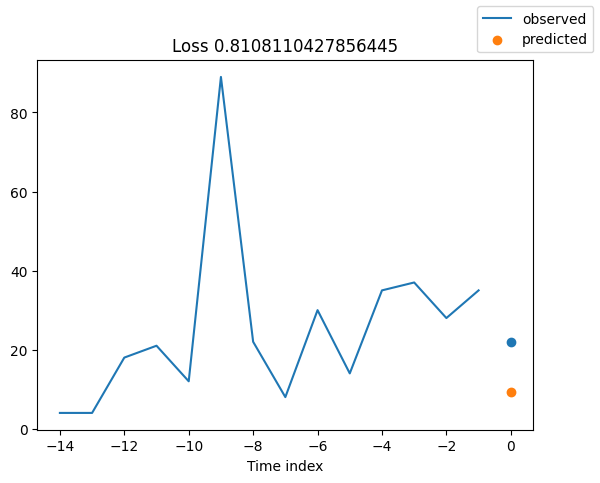

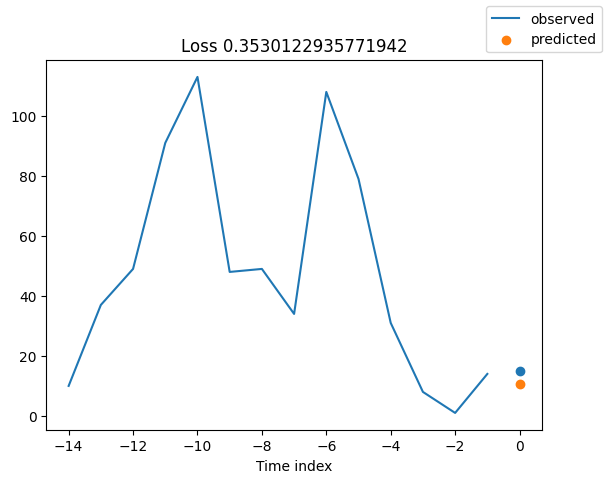

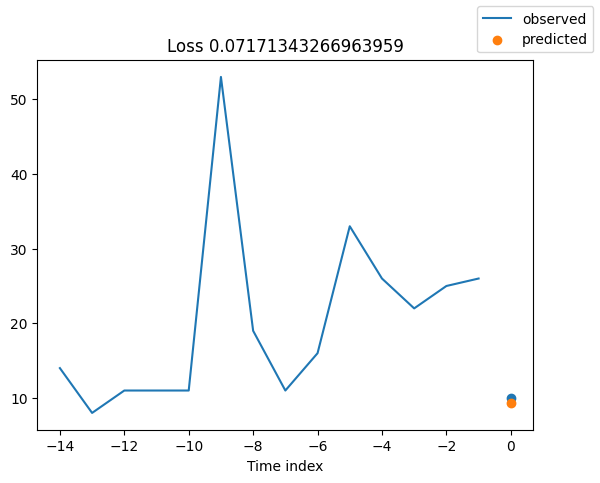

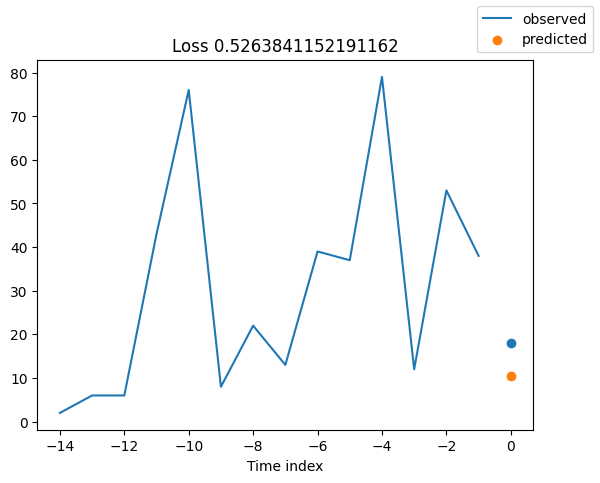

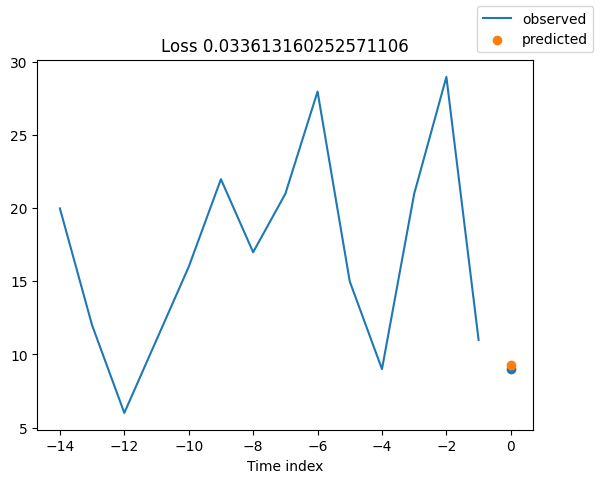

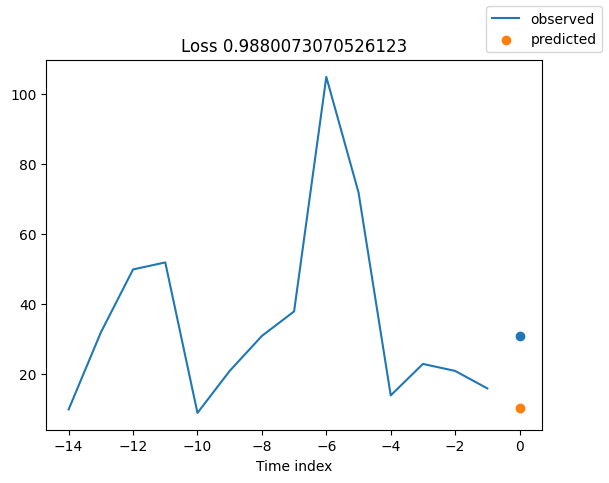

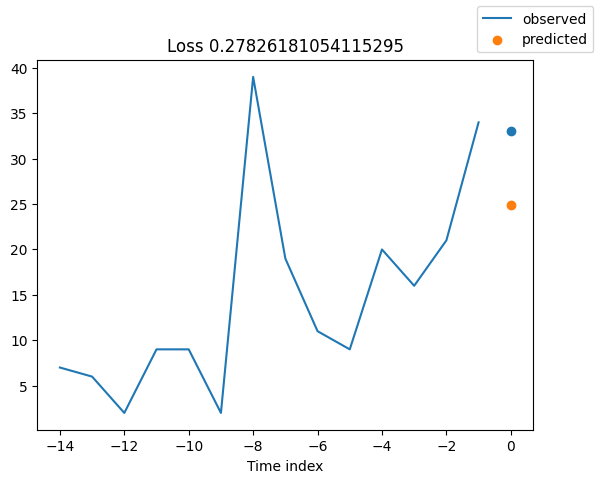

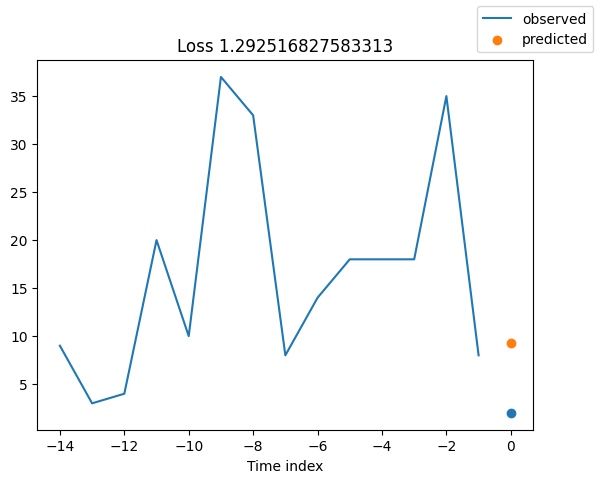

In [27]:
raw_predictions = model.predict(val_dataloader, mode="raw", return_x=True, trainer_kwargs=dict(accelerator="cpu"))
for idx in range(23):  # plot 10 examples
    model.plot_prediction(raw_predictions.x, raw_predictions.output, idx=idx, add_loss_to_title=True)

In [51]:
train_eval_df = class_df_X[:-2000].loc[class_df_X['group'] == '1125']
test_eval_df = class_df_X[-2000:].loc[class_df_X['group'] == '1125']
cutoff = len(train_eval_df)
train_eval_df

,temp_arr,temp_arr_3,temp_arr_5,temp_arr_7,temp_arr_14,temp_arr_30,temp_arr_60,temp_dep,temp_dep_3,temp_dep_5,...,wheat3,wheat5,wheat7,wheat14,wheat30,wheat60,dow,time_idx,group,value
5110,40.499881,44.949455,42.951524,32.786755,40.038207,41.295869,35.708032,58.337977,60.789620,60.407546,...,6.645570,7.278481,5.221519,2.531646,11.748999,16.688919,0,0,1125,46.0
5111,42.099817,42.625169,42.195336,40.770517,40.412322,37.968638,37.188570,55.886333,65.931704,59.221524,...,6.645570,7.120253,3.639241,1.898734,11.748999,16.688919,1,1,1125,73.0
5112,43.843031,42.067977,44.949455,42.951524,40.308843,39.600414,41.001353,56.117169,65.111836,60.789620,...,6.645570,6.645570,7.278481,4.430380,24.566088,24.566088,2,2,1125,75.0
5113,41.574465,40.499881,42.625169,42.195336,37.307968,33.121070,45.665844,60.932898,58.337977,65.931704,...,6.645570,6.645570,7.120253,6.645570,20.160214,20.694259,3,3,1125,27.0
5114,38.740747,42.099817,42.067977,44.949455,31.401735,32.866354,47.225981,62.548754,55.886333,65.111836,...,21.835443,6.645570,6.645570,5.221519,24.966622,20.694259,4,4,1125,21.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5741,48.579161,52.869538,55.337101,60.375706,74.560217,70.659874,82.806654,72.960280,67.738597,81.262437,...,42.879747,45.253165,42.879747,53.006329,46.995995,58.077437,1,631,1125,27.0
5742,49.518427,51.166123,53.323251,58.178779,74.401019,73.023959,83.992677,78.277481,65.692908,78.102364,...,42.879747,42.879747,46.202532,53.006329,45.794393,58.077437,2,632,1125,31.0
5743,53.808804,50.234817,52.869538,55.337101,75.133328,73.971185,80.856483,76.812863,71.702619,67.738597,...,42.088608,42.879747,45.253165,73.101266,46.194927,58.077437,3,633,1125,9.0
5744,55.066465,48.579161,51.166123,53.323251,74.241821,66.966489,66.695853,80.450529,72.960280,65.692908,...,41.297468,42.879747,42.879747,43.829114,45.393858,62.082777,4,634,1125,7.0


In [ ]:
train_data = train_eval_df.iloc[:14]
model.eval()
i = train_data['time_idx'].values[-1]
pred_len = 1
preds = []
while i <= cutoff - 1:
    train_data = train_data.append(train_eval_df[i*pred_len:(i+1)*pred_len], ignore_index=True)
    cur_dow = (int(train_data['time_idx'].values[-1])) % 7
    i += 1
    train_data.loc[train_data.index[-1*pred_len:],'dow'] = cur_dow
    train_time_series_dataset = TimeSeriesDataSet.from_dataset(dataset_with_covariates,
                                                               train_data,
                                                               predict=False,
                                                               stop_randomization=True)

    predictions = model.predict(train_time_series_dataset, return_y=True)
    res_value = (pd.DataFrame(predictions.output[-1]).values)
    train_data.loc[train_data.index[-1*pred_len:],'value'] = float(int(res_value))
    preds.append(float(int(res_value)))
    train_data = train_data.iloc[-14:]

In [ ]:
test_data = train_eval_df.iloc[-14:]
i = test_data['time_idx'].values[-1]
last_idx = test_eval_df['time_idx'].values[-1]
pred_len = 1
test_preds = []
init_i = i
while i < last_idx:
    test_data = test_data.append(test_eval_df[(i-init_i)*pred_len:((i-init_i)+1)*pred_len],
                                 ignore_index=True)
    cur_dow = (int(test_data['time_idx'].values[-1])) % 7
    i += 1
    test_data.loc[test_data.index[-1*pred_len:],'dow'] = cur_dow
    try:
        test_time_series_dataset = TimeSeriesDataSet.from_dataset(dataset_with_covariates,
                                                                  test_data,
                                                                  predict=False,
                                                                  stop_randomization=True)
    except AssertionError:
        break
    predictions = model.predict(test_time_series_dataset, return_y=True)
    res_value = (pd.DataFrame(predictions.output[-1]).values)
    test_data.loc[test_data.index[-1*pred_len:],'value'] = float(int(res_value))
    test_preds.append(float(int(res_value)))
    test_data = test_data.iloc[-14:]


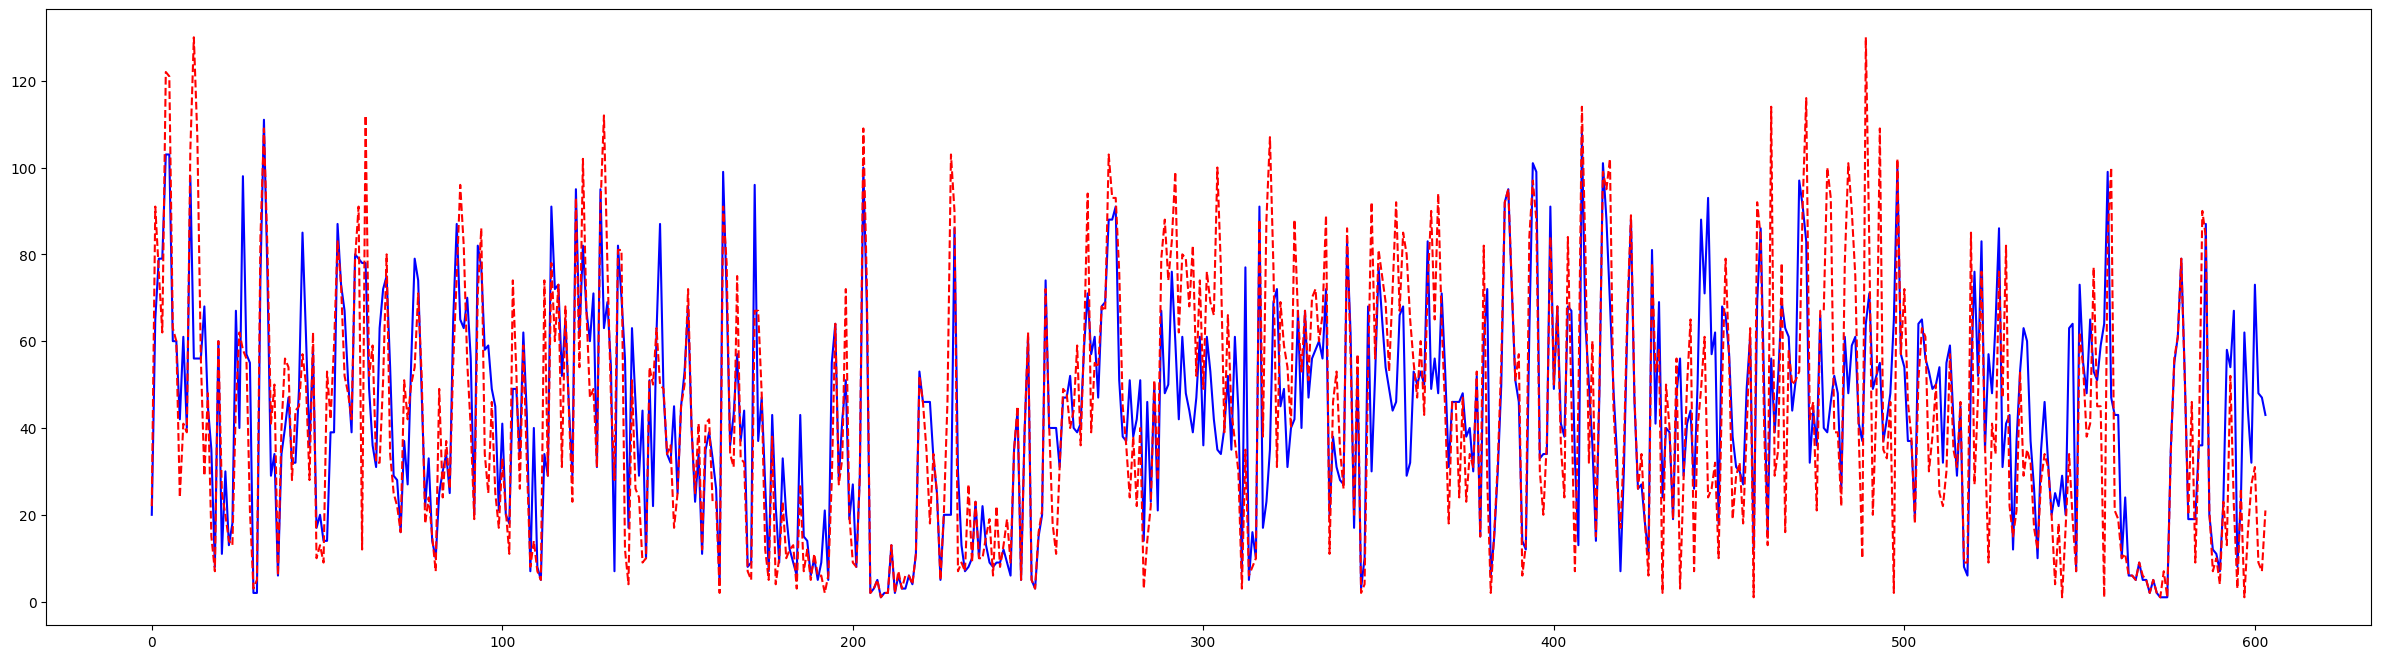

In [108]:
train_Y = train_eval_df['value'].values[15:]
plt.figure(figsize=(30,8))
plt.plot(preds, 'b')
plt.plot(train_Y, 'r', linestyle='dashed')

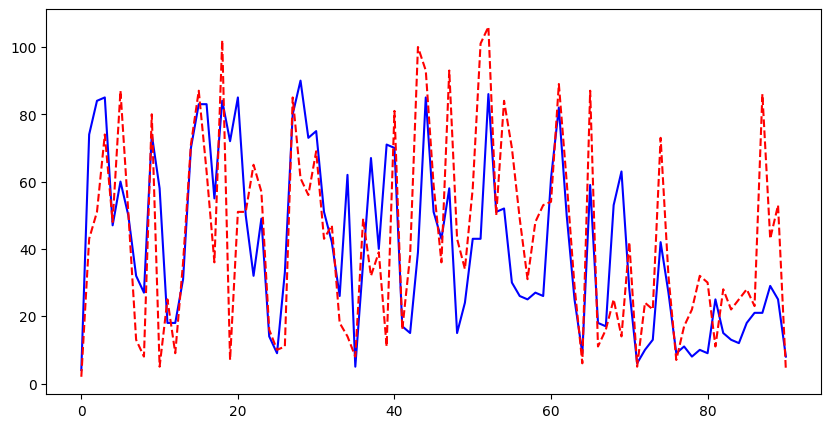

In [124]:
test_Y = test_eval_df['value'].values
plt.figure(figsize=(10,5))
plt.plot(test_preds, 'b')
plt.plot(test_Y, 'r', linestyle='dashed')